In [1]:
class User:
    def __init__(self, name, label="none"): 
        self.id = name
        self.label = label
        self.advisors = [] #neighbors
        self.providers = []
        self.interactions = {}
        self.total_interactions = 0
        self.provider_raputation = {}
        self.advisor_reputation = {}
        self.decay = 1 #longitivity
        self.phi = 0.5 #w
        self.epsilon = 1 #uncertainity
        self.limit = 0 #tolarance limit
#         self.alpha = 0.8 #consumer confidence
        self.satisfaction = {}
        self.disatisfaction = {}
        self.b_satisfaction = {}
        self.b_disatisfaction = {}

        
    def reset(self):
        self.advisors = [] #neighbors
        self.providers = []
        self.interactions = {}
        self.total_interactions = 0
        self.provider_raputation = {}
        self.advisor_reputation = {}
        self.satisfaction = {}
        self.disatisfaction = {}
        self.b_satisfaction = {}
        self.b_disatisfaction = {}
        
            
    def interact(self, provider, rating):
        if provider.id != self.id:
            if provider in self.providers:
                ratelist = self.interactions[provider]
            else:
                ratelist = []
                self.providers.append(provider)

            ratelist.append(rating)
            self.interactions[provider] = ratelist
            self.total_interactions += 1

            self.eval_provider(provider, rating)
            self.eval_provider(provider, rating, bayes = True)
        else:
            print('I cant interact with myself')
        
        
    def eval_provider(self, provider, rating, bayes = False):
        exp_val_n = len(self.interactions[provider])

        rj = (1- rating) * self.phi #disatisfaction self.phi = w, rj = ds
        sj = (1+ rating) * self.phi #satisfaction self.phi = w  sj = sj
        
        if bayes:
            if provider in self.b_satisfaction:
                cumilative_satisfaction = self.b_satisfaction[provider]
                cumilative_disatisfaction = self.b_disatisfaction[provider]
                cumilative_satisfaction += sj
                cumilative_disatisfaction += rj
            else:
                cumilative_satisfaction = sj
                cumilative_disatisfaction = rj
            self.b_satisfaction[provider] = cumilative_satisfaction
            self.b_disatisfaction[provider] = cumilative_disatisfaction
        else:
            decay_factor = self.decay **(exp_val_n - self.limit)
            rj *= decay_factor
            sj *= decay_factor
            self.limit += 1
            if provider in self.satisfaction:
                cumilative_satisfaction = self.satisfaction[provider]
                cumilative_disatisfaction = self.disatisfaction[provider]
                cumilative_satisfaction += sj
                cumilative_disatisfaction +=rj
            else:
                cumilative_satisfaction = sj
                cumilative_disatisfaction = rj
            self.satisfaction[provider] = cumilative_satisfaction
            self.disatisfaction[provider] = cumilative_disatisfaction
        
        self.get_belief(provider)
    
    def get_belief(self, provider):
        belief = 0 
        disbelief = 0 
        uncertainity = 0
        if provider in self.satisfaction:
            cum_sat = self.satisfaction[provider]
            cum_dis = self.disatisfaction[provider]
            total_sat_dit = cum_dis+cum_sat
            den = total_sat_dit + self.epsilon 
            belief = cum_sat /(den)
            disbelief = cum_dis /(den)
            uncertainity = self.epsilon / (den)    
        return belief, disbelief, uncertainity
        
        
    def provider_raputation(self, provider):
        return provider_raputation[provider]
    
    def get_providers(self):
        return self.providers
        

    def get_similarity(self, advisor):

        common_providers = [x for x in advisor.get_providers() if x in self.get_providers()]
        similarity = -100 #note this is just for checking if the advisor has a common vendor
        
        if len(common_providers) > 0:
            cum_dist = 0
            for p in common_providers:
                    
                    a_bel, a_disbel, a_unc = self.get_belief(p)
                    b_bel, b_disbel, b_unc = advisor.get_belief(p)
                    nonsqrt= self.get_distance(advisor, p)
                    dist = nonsqrt** (1/2)
                    dist = dist/(2**(1/2))
                    cum_dist += dist
            meanormilsed_distance = cum_dist/len(common_providers)
            similarity = 1 - meanormilsed_distance
        return similarity
    
    def get_distance(self, advisor, p):
        a_bel, a_disbel, a_unc = self.get_belief(p)
        b_bel, b_disbel, b_unc = advisor.get_belief(p)
        nonsqrt=((a_bel - b_bel)**2) + ((a_disbel - b_disbel)**2) + ((a_unc - b_unc)**2)
        return nonsqrt
            
    def get_global_crediblity(self):
        cum_bel = 0
#         print('cum_bel'+str(cum_bel))
#         print('self.providers'+str(self.providers))
        p_count = 0
        gp = 0
        for p in self.providers:
            b ,_ , _ = p.get_belief(self)
            cum_bel += b
            p_count += 1
            
        if p_count > 0:
            gp = cum_bel/p_count
#         print('gp'+str(gp))
        return gp
            
    
    def set_adivsors(self, neigbors):
        self.advisors = neigbors
    def add_an_adivsor(self, neigbor):
        self.advisors.append(neigbor)
    
    def get_id(self):
        self.id
    

    def my_bayes(self, p):
        sat = 0
        dis = 0
        if p in self.b_satisfaction:
            sat = self.b_satisfaction[p]
            dis = self.b_disatisfaction[p]
        return sat, dis
    

    
    def p_g_reputation(self, provider, all_advisors, alpha = 0.8, filter_threshold = 0.5, iwindow=False):
        sim_count = 0
        gc_count = 0
        gp_count = 0
        p_rep = 0
        g_rep = 0
        for _, a in all_advisors.items():
            if a.id != self.id:
                ap_bel, _, _ = a.get_belief(provider)
                sim = self.get_similarity(a)
                if sim != -100: #meaning have no common vendos
                    sim_count += 1
                    if sim > filter_threshold:
                        p_rep += (sim * ap_bel)
                else:
                    gc = a.get_global_crediblity()
                    gp_count += 1
                    g_rep += (gc * ap_bel)
#                     print('ap_bel'+str(ap_bel))
        
        reputation = 0
        if iwindow:
            ap_bel, _, _ = self.get_belief(provider)
            p_rep = ap_bel
            sim_count = 1
            
        r = 0
        g = 0
        if sim_count > 0:
            r = (alpha * p_rep)/sim_count

        if  gp_count > 0:
            g = ((1 - alpha) * g_rep)/gp_count
#         print('g_rep '+str(g_rep))
#         print('p_rep '+str(p_rep))
#         print('g '+str(g))
#         print('r '+str(r))
        reputation = r + g
#         print('reputation'+str(reputation))
        
            
        return reputation
    
    def trust(self, provider, all_advisors,  beta=0.5, trust_propensity=0.5):
        rep = self.p_g_reputation(provider, all_advisors)
        t = (beta * trust_propensity ) + ((1-beta) * rep)
        b, d, u = self.get_belief(provider)
        trust = b + (t * u)
        trust_dash = d + ((1 - t) * u)
#         print("Sum test ="+str(trust + trust_dash))
        return trust, trust_dash
    

In [2]:
class Consumer(User):
    def __init__(self, name, label="C"):
        User.__init__(self,name, label)
        

class Producer(User):
    def __init__(self, name, label="P"):
        User.__init__(self,name, label)

# class Advisor(Users):
#     def __init__(self, name):
#         Users.__init__(self,name)

In [5]:
import random

class Experiment:
    def __init__(self, scenario, nconsumer, nproducer, ntransactions, seed=100):
        self.scenario = scenario
        self.nconsumer = nconsumer
        self.nproducer = nproducer
        self.ntransactions = ntransactions
        self.nfaket = int(ntransactions/10)
        self.init_trans = ntransactions - self.nfaket
        self.consumers = {}
        self.producers = {}
        random.seed(seed)
        self.graphdata = {}
        self.graphdata_trust = {}
        self.graphdata_dtrust = {}
        self.graphdata_bayes = {}
        self.graphdata_modBRS = {}
        self.producer_id_start_range = 200
        self.consumer_id_start_range = 100
        self.alpha = 0.8
        self.filter_threshold = 0.5
        self.all_advs = []
        self.interval_count = 0      
        self.total_transactions_for_all = 0
        self.target = False
        self.pair_list = []
        self.iwindow = False
        self.start()
        
        
    def start(self, excludelist=[]):
        consumers = {}
        producers = {}
        c_dic = {}
        c_p_reps = []
        c_p_t_dic = {}
        c_p_d_dic = {}
        c_p_t = []
        c_p_d = []

        c_dic_bayes = {}
        c_dic_modBRS = {}
        c_p_reps_bayes = []
        c_p_reps_modBRS = []
        for x in range(self.nconsumer):
            c = Consumer(self.consumer_id_start_range+x)
            consumers[c.id] = c
            c_dic[c.id] = c_p_reps
            c_p_t_dic[c.id] = c_p_t
            c_p_d_dic[c.id] = c_p_d
    
            self.graphdata[c.id] = c_dic
            self.graphdata_trust[c.id] = c_p_t_dic
            self.graphdata_dtrust[c.id] = c_p_d_dic
            
            c_dic_bayes[c.id] = c_p_reps_bayes
            self.graphdata_bayes[c.id] = c_dic_bayes
            
            c_dic_modBRS[c.id] = c_p_reps_modBRS
            self.graphdata_modBRS[c.id] = c_dic_modBRS
        for y in range(self.nproducer):
            p = Producer(self.producer_id_start_range+y)
#             producers.append(p)
            producers[p.id] = p
            c_dic[p.id] = c_p_reps
            c_p_t_dic[p.id] = c_p_t
            c_p_d_dic[p.id] = c_p_d
            self.graphdata[p.id] = c_dic
            self.graphdata_trust[p.id] = c_p_t_dic
            self.graphdata_dtrust[p.id] = c_p_d_dic
            c_dic_bayes[p.id] = c_p_reps_bayes
            self.graphdata_bayes[p.id] = c_dic_bayes
            c_dic_modBRS[p.id] = c_p_reps_modBRS
            self.graphdata_modBRS[p.id] = c_dic_modBRS
        print('experiment'+str(self.scenario)+' initialised with'+str(len(consumers))+" c and "+str(len(producers))+" p")
        self.consumers = consumers
        self.producers = producers
        
    def reset_all(self):
        for _, c in self.consumers.items():
            c.reset()
        for _, p in self.producers.items():
            p.reset()
        self.graphdata = {}
        self.graphdata_bayes = {}
        self.graphdata_modBRS = {}
        self.start()
    
    def i_transactions(self, exclude_pair=[], pair_list =[], target=False, t_per_user=3):
        self.init_trans = t_per_user * len(self.consumers)
        self.target = target
        self.pair_list = pair_list
        pids = [x for x in self.producers]
        adis = [x for x in self.consumers]
        all_advs = [self.consumers[x] for x in adis]
        all_prvs = [self.producers[x] for x in pids]
        self.all_advs = all_advs
        self.all_prvs = all_prvs
        self.pids = pids
        print('initalizing '+str(self.scenario)+'  with'+str(t_per_user)+" t_per_user for "+str(len(self.consumers))+' c')
        print(self.init_trans)
        for _,c in self.consumers.items():

            for i in range(t_per_user):
                pi = random.choice(pids)
                p = self.producers[pi]
                if (not (c.id, p.id) in exclude_pair):
                    self.interact_normally(c, p)
                        

    def interact_normally(self, c, p, n_trans= 1):
#         print(str(n_trans)+' normal transaction')
        for i in range(n_trans):
#             print(str(i)+'th normal transaction')
            r_i = random.randint(0,5)
            if r_i == 1:
                self.agree(c, p, 1)
            elif r_i == 2:
                self.disagree(c, p, 1)
            elif r_i == 3:
                self.c_agree_p_disagree(c, p, 1)
            else:
                self.p_agree_c_disagree(c, p, 1)
    
    def update_forall(self, interval= 10):
        self.interval_count += 1
        if self.target:
#             if self.interval_count % interval == 0:
                self.update_for_targets(self.pair_list)
        else:
            if self.interval_count % interval == 0:
                for _,c in self.consumers.items():
                    for _,p in self.producers.items():
                        self.update_data(c, p)
        
        self.total_transactions_for_all += 1
    
    def update_for_targets(self, pair_list):
        for co,pr in pair_list:
            c = self.consumers[co]
            p = self.producers[pr]
            self.update_data(c,p)
        
            
    def update_data(self, c, p):
        
        rep = c.p_g_reputation(p, self.consumers, self.alpha, self.filter_threshold, self.iwindow)
        trust, dtrust = c.trust(p, self.consumers, beta=0.5, trust_propensity=0.5)
        b_rep = self.bayes(self.consumers, p)
        m_rep = self.mod_BRS(c, p, self.consumers, self.producers, i_S = 0.5, i_D = 0.5)
        
        if c.id in self.graphdata:
            c_dic = self.graphdata[c.id]
            c_dic_t = self.graphdata_trust[c.id]
            c_dic_d = self.graphdata_dtrust[c.id]
            if p.id in c_dic:
                c_p_reps = c_dic[p.id]
                c_p_t = c_dic_t[p.id]
                c_p_d = c_dic_d[p.id]

        c_p_reps.append(rep)
        c_p_t.append(trust)
        c_p_d.append(dtrust)
        c_dic[p.id] = c_p_reps
        c_dic_t[p.id] = c_p_t
        c_dic_d[p.id] = c_p_d
        self.graphdata[c.id] = c_dic
        self.graphdata_trust[c.id] = c_dic_t
        self.graphdata_dtrust[c.id] = c_dic_d

        if c.id in self.graphdata_bayes:
            c_dic_bayes = self.graphdata_bayes[c.id]
            if p.id in c_dic_bayes:
                c_p_reps_bayes = c_dic_bayes[p.id]

        c_p_reps_bayes.append(b_rep)
        c_dic_bayes[p.id] = c_p_reps_bayes
        self.graphdata_bayes[c.id] = c_dic_bayes

        if c.id in self.graphdata_modBRS:
            c_dic_modBRS = self.graphdata_modBRS[c.id]
            if p.id in c_dic_modBRS:
                c_p_reps_mod = c_dic_modBRS[p.id]

        c_p_reps_mod.append(m_rep)
        c_dic_modBRS[p.id] = c_p_reps_mod
        self.graphdata_modBRS[c.id] = c_dic_modBRS
        
        
    
    def agree(self, c, p, n_interactions, rate=1):
        for i in range(n_interactions):
            c.interact(p, rate)
            p.interact(c, rate)
            self.update_forall()
            



    def disagree(self, c, p, n_interactions,rate=-1):
        self.agree(c, p, n_interactions,rate)
        

    def c_agree_p_disagree(self, c, p, n_interactions, p_rate=1, n_rate=-1):
        for i in range(n_interactions):
            c.interact(p, p_rate)
            p.interact(c, n_rate)
            self.update_forall()
            
            

    def p_agree_c_disagree(self, c, p, n_interactions, p_rate=1, n_rate=-1):
        for i in range(n_interactions):
            c.interact(p, n_rate)
            p.interact(c, p_rate)
            self.update_forall()
            

    
    def mod_BRS(self, c, provider, all_advisors, all_providers, i_S = 0.5, i_D = 0.5):
        rep = 0
        reputation = 0
        advisor_count = 0
        for _,a in all_advisors.items():
#             if a.id != c.id:
            if provider in a.b_satisfaction:
                advisor_count += 1
                e_p = (i_S + a.b_satisfaction[provider])/ (i_S + i_D + a.b_satisfaction[provider] + a.b_disatisfaction[provider])
                a_cred = 0
                sum_sat = 0
                sum_dis = 0
                for _,p in all_providers.items():
                    if a in p.b_satisfaction:
                        sum_sat += p.b_satisfaction[a]
                        sum_dis += p.b_disatisfaction[a]

                if (sum_sat+sum_dis) > 0:
                    a_cred = 1 - (sum_dis/(sum_sat+sum_dis))

#                 print('C '+str(a.id)+' for provider '+str(p.id)+' e_p :'+str(e_p))
#                 print('C '+str(a.id)+' a_cred :'+str(a_cred))

                rep += (e_p * a_cred)
        
        if advisor_count > 0:
            reputation = rep / advisor_count
        return reputation
    
    def bayes(self, l_consumers, xprovider):
        cum_sat = 0
        cum_dis = 0
        for _, cm in l_consumers.items():
        #     print(cm.id)
            s, d = cm.my_bayes(xprovider)
#             print('For user = '+str(cm.label)+','+str(cm.id)+' S = '+str(s)+" D = "+str(d))

            cum_sat += s
            cum_dis += d
#         print(str(cum_sat)+'/'+str(cum_sat+ cum_dis))
        bayes = (1 + cum_sat) / (2 + (cum_sat+ cum_dis))
        return bayes
    
    def ballot_stuffing_with_init(self, attacker_id, n_fake_t=15, n_colluders=4, n_victims=3):
        p = self.producers[attacker_id]
        print(p.id)
        for _, c in self.consumers.items():
            for _, p in self.producers.items():
                if c.id == 100:
                    if p.id == attacker_id:
                        print(c.id)
                        self.agree(c, p, n_fake_t)
                    if p.id == 201:
                        self.p_agree_c_disagree(c, p, 1)
                        self.disagree(c, p, 9)
                    if p.id == 202:
                        self.p_agree_c_disagree(c, p, 2)
                        self.disagree(c, p, 8)
                    if p.id == 203:
                        self.p_agree_c_disagree(c, p, 1)
                        self.disagree(c, p, 9)
                    if p.id == 204:
                        self.p_agree_c_disagree(c, p, 2)
                        self.disagree(c, p, 8)
                elif c.id == 101:
                    if p.id == attacker_id:
                        print(c.id)
                        self.agree(c, p, n_fake_t)
                    if p.id == 201:
                        self.p_agree_c_disagree(c, p, 1)
                        self.disagree(c, p, 9)
                    if p.id == 202:
                        self.p_agree_c_disagree(c, p, 1)
                        self.disagree(c, p, 9)
                    if p.id == 203:
                        self.p_agree_c_disagree(c, p, 2)
                        self.disagree(c, p, 8)
                    if p.id == 204:
                        self.p_agree_c_disagree(c, p, 2)
                        self.disagree(c, p, 8)
                elif c.id == 102:
                    if p.id == attacker_id:
                        print(c.id)
                        self.agree(c, p, n_fake_t)
                    if p.id == 201:
                        self.p_agree_c_disagree(c, p, 2)
                        self.disagree(c, p, 8)
                    if p.id == 202:
                        self.p_agree_c_disagree(c, p, 2)
                        self.disagree(c, p, 8)
                    if p.id == 203:
                        self.p_agree_c_disagree(c, p, 1)
                        self.disagree(c, p, 9)
                    if p.id == 204:
                        self.p_agree_c_disagree(c, p, 2)
                        self.disagree(c, p, 8)
                elif c.id == 103:
                    if p.id == attacker_id:
                        print(c.id)
                        self.agree(c, p, n_fake_t)
                    if p.id == 201:
                        self.p_agree_c_disagree(c, p, 1)
                        self.disagree(c, p, 9)
                    if p.id == 202:
                        self.p_agree_c_disagree(c, p, 1)
                        self.disagree(c, p, 9)
                    if p.id == 203:
                        self.p_agree_c_disagree(c, p, 1)
                        self.disagree(c, p, 9)
                    if p.id == 204:
                        self.p_agree_c_disagree(c, p, 2)
                        self.disagree(c, p, 8)
                elif c.id == 104:
                    if p.id == attacker_id:
                        self.disagree(c, p, 1)
                    if p.id == 201:
                        self.agree(c, p, 5)
                        self.p_agree_c_disagree(c, p, 1)
                    if p.id == 202:
                        self.p_agree_c_disagree(c, p, 1)
                        self.disagree(c, p, 1)
                        self.agree(c, p, 3)
                elif c.id == 105:
                    if p.id == attacker_id:
                        self.disagree(c, p, 2)
                    if p.id == 201:
                        self.agree(c, p, 6)
                    if p.id == 202:
                        self.p_agree_c_disagree(c, p, 1)
                        self.disagree(c, p, 1)
                        self.agree(c, p, 2)
                elif c.id == 106:
                    if p.id == attacker_id:
                        self.disagree(c, p, 3)
                    if p.id == 201:
                        self.agree(c, p, 9)
                        self.p_agree_c_disagree(c, p, 1)
                        self.disagree(c, p, 4)
                    if p.id == 202:
                        self.agree(c, p, 5)
                elif c.id == 107:
                    if p.id == attacker_id:
                        self.agree(c, p, 15)
                    if p.id == 203:
                        self.p_agree_c_disagree(c, p, 1)
                        self.disagree(c, p, 9)
                    if p.id == 204:
                        self.p_agree_c_disagree(c, p, 1)
                        self.disagree(c, p, 9)
                elif c.id == 108:
                    if p.id == attacker_id:
                        self.agree(c, p, 15)
                    if p.id == 203:
                        self.p_agree_c_disagree(c, p, 1)
                        self.disagree(c, p, 9)
                    if p.id == 204:
                        self.p_agree_c_disagree(c, p, 1)
                        self.disagree(c, p, 9)
                elif c.id == 109:
                    if p.id == attacker_id:
                        self.disagree(c, p, 2)
                    if p.id == 203:
                        self.p_agree_c_disagree(c, p, 1)
                        self.agree(c, p, 6)
                        self.disagree(c, p, 3)
                    if p.id == 204:
                        self.p_agree_c_disagree(c, p, 1)
                        self.agree(c, p, 6)
                        self.disagree(c, p, 5)
                elif c.id == 110:
                    if p.id == 201:
                        self.agree(c, p, 9)
                    if p.id == 202:
                        self.p_agree_c_disagree(c, p, 1)
                        self.agree(c, p, 4)
                        self.disagree(c, p, 3)
                
                
                
    def get_rep(self, cid, pid, reptype='rob', alpha=0.8, filter_threshold=0.3):
        c = self.consumers[cid]
        p = self.producers[pid]
        if reptype=='rob':
#             print(c.id)
            return c.p_g_reputation(p, self.consumers, alpha, filter_threshold)
        elif reptype=='bayes':
            return self.bayes(self.consumers, p)
        elif reptype=='mod':
            return self.mod_BRS(c, p, self.consumers, self.producers, i_S = 0.5, i_D = 0.5)
            
    
    def ballot_stuffing(self, attacker_id, observers_id=[], n_fake_t=70, n_colluders=1, n_victims=5):
        colluders = []
        p = self.producers[attacker_id]
        few_producers =  []
        for i in range(n_colluders):
            colluder_id = self.consumer_id_start_range+i
            if not observers_id in observers_id:
                colluders.append(self.consumers[colluder_id])
        
        fake_per_c = int(n_fake_t/n_colluders)
        for c in colluders:
            self.agree(c, p, int(fake_per_c * 9/10))
            already_victim = []
            for i in range(n_victims):
                pi = random.choice(self.pids)
                p2 = self.producers[pi]
                if p != p2 and (not p2 in already_victim):
                    already_victim.append(p2)
                    self.p_agree_c_disagree(c, p2, int(fake_per_c*1/10))
                    self.disagree(c, p2, int(fake_per_c*8/10))
                      
 
    def bad_mouthing(self, victim, observers_id=[], n_fake_t=70, n_colluders=5, n_victims=5):
        colluders = []
        p = self.producers[victim]
        for i in range(n_colluders):
            colluder_id = self.consumer_id_start_range+i
            if not observers_id in observers_id:
                colluders.append(self.consumers[colluder_id])
        fake_per_c = int(n_fake_t/n_colluders)
        for c in colluders:
            self.disagree(c, p, int(fake_per_c * 9/10))
            self.p_agree_c_disagree(c, p, int(fake_per_c*4/10))
            
    def majority_descrimination(self, attacker,  observers_id=[], n_fake_t=70):
        p = self.producers[attacker]
        for _, c in self.consumers.items():
            if c.id <= 104:
                #favoured group
#                     int(self.consumer_id_start_range+ (self.consumer_id_start_range1/10))
                self.agree(c, p, n_fake_t)
            else:
                self.disagree(c, p, int(n_fake_t * 9/10))
                self.p_agree_c_disagree(c, p, int(n_fake_t*4/10))

                                   
    def minority_descrimination(self, attacker,  observers_id=[], n_fake_t=70):
        p = self.producers[attacker]
        for _, c in self.consumers.items():
            if c.id <= 104:
                #favoured group
#                     int(self.consumer_id_start_range+ (self.consumer_id_start_range1/10))
                self.disagree(c, p, n_fake_t)
            else:
                self.agree(c, p, n_fake_t)
    
    def complementary(self, attacker_cid, victim_pid, n_fake_t=70, case=1):
        p = self.producers[victim_pid]
        attacker_c = self.consumers[attacker_cid]

        ##good provider
        if case == 1:
            for _, c in self.consumers.items():
                if c.id != attacker_c.id:
                    self.agree(c, p, int(n_fake_t * 9/10)) ##first making a good provider    
            else:
                self.p_agree_c_disagree(c, p, n_fake_t*2)
                self.c_agree_p_disagree(c, p, n_fake_t)
        elif case == 2:
            for _, c in self.consumers.items():
                if c.id != attacker_c.id:
                    self.disagree(c, p, int(n_fake_t * 9/100)) ##first making a bad provider    
            else:
                self.p_agree_c_disagree(c, p, n_fake_t*2)
                self.c_agree_p_disagree(c, p, n_fake_t)
            
        

        
    
    def plot(self, targetu, targetp, dlen=30):
        import matplotlib.pyplot as plt
        import numpy as np
        
        u_d = self.graphdata[targetu]
        len(u_d)
        p_d = u_d[targetp]
        print(len(p_d))
        
        u_d_b = self.graphdata_bayes[targetu]
        p_d_b = u_d_b[targetp]
        print(len(p_d_b))
        
        u_d_m = self.graphdata_modBRS[targetu]
        p_d_m = u_d_m[targetp]
        
        p_d = p_d
        p_d_b = p_d_b
        p_d_m = p_d_m
        print(len(p_d_m))

#         print(p_d)
        # Prepare the data
        x = np.linspace(0, len(p_d), len(p_d))
        x_b = np.linspace(0, len(p_d_b), len(p_d_b))
        x_m = np.linspace(0, len(p_d_b), len(p_d_b))

        # Plot the data
        plt.plot(x_b, p_d_b, alpha=0.7, label='BRS')
        plt.plot(x, p_d, alpha=0.7, label='ROBUSTRA')
        plt.plot(x_m, p_d_m, alpha=0.3, label='MBTE')
        plt.xlabel('number of transactions')
        plt.ylabel('reputation')

        # Add a legend
        plt.legend()

        # Show the plot
        plt.show()
        return plt
    def plot_re_entry(self, targetu, targetp, dlen=30):
        import matplotlib.pyplot as plt
        import numpy as np
        
        u_d = self.graphdata[targetu]
        len(u_d)
        p_d = u_d[targetp]
        
        
        u_d_b = self.graphdata_bayes[targetu]
        p_d_b = u_d_b[targetp]
        
        
        u_d_m = self.graphdata_modBRS[targetu]
        p_d_m = u_d_m[targetp]
        
        p_d = p_d[:dlen]
        p_d_b = p_d_b[:dlen]
        p_d_m = p_d_m[:dlen]
        print(len(p_d))
        print(len(p_d_b))
        print(len(p_d_m))

#         print(p_d)
        # Prepare the data
        x = np.linspace(0, len(p_d), len(p_d))
        x_b = np.linspace(0, len(p_d_b), len(p_d_b))
        x_m = np.linspace(0, len(p_d_b), len(p_d_b))

        # Plot the data
        plt.plot(x_b, p_d_b, alpha=0.7, label='BRS')
        plt.plot(x, p_d, alpha=0.7, label='ROBUSTRA')
        plt.plot(x_m, p_d_m, alpha=0.3, label='MBTE')
        plt.xlabel('number of transactions')
        plt.ylabel('reputation')

        # Add a legend
        plt.legend()

        # Show the plot
        plt.show()
        return plt
    
    def plot_intialwindow(self, targetu, targetp, dlen=30):
        import matplotlib.pyplot as plt
        import numpy as np
        
        u_d = self.graphdata[targetu]
        len(u_d)
        p_d = u_d[targetp]
        
        
        u_d_b = self.graphdata_bayes[targetu]
        p_d_b = u_d_b[targetp]
        
        
        u_d_m = self.graphdata_modBRS[targetu]
        p_d_m = u_d_m[targetp]
        
        p_d = p_d[:dlen]
        p_d_b = p_d_b[:dlen]
        p_d_m = p_d_m[:dlen]
        print(len(p_d))
        print(len(p_d_b))
        print(len(p_d_m))

#         print(p_d)
        # Prepare the data
        x = np.linspace(0, len(p_d), len(p_d))
        x_b = np.linspace(0, len(p_d_b), len(p_d_b))
        x_m = np.linspace(0, len(p_d_b), len(p_d_b))

        # Plot the data
        plt.plot(x_b, p_d_b, alpha=0.7, label='BRS')
        plt.plot(x, p_d, alpha=0.7, label='ROBUSTRA')
        plt.plot(x_m, p_d_m, alpha=0.3, label='MBTE')
        plt.xlabel('number of transactions')
        plt.ylabel('reputation')

        # Add a legend
        plt.legend()

        # Show the plot
        plt.show()
        return plt
    
    def plot_trust(self, targetu, targetp, dlen=30, start=0):
        import matplotlib.pyplot as plt
        import numpy as np
        
        u_d = self.graphdata[targetu]
        len(u_d)
        p_d = u_d[targetp]
        p_d = p_d[start:dlen]
        
        
        u_d_b = self.graphdata_trust[targetu]
        p_d_b = u_d_b[targetp]
        p_d_b = p_d_b[start:dlen]
        
        
        u_d_m = self.graphdata_dtrust[targetu]
        p_d_m = u_d_m[targetp]
        p_d_m = p_d_m[start:dlen]
        
        

#         print(p_d)
        # Prepare the data
        x = np.linspace(0, len(p_d), len(p_d))
        x_b = np.linspace(0, len(p_d_b), len(p_d_b))
        x_m = np.linspace(0, len(p_d_m), len(p_d_m))

        # Plot the data
        plt.plot(x_b, p_d_b, alpha=0.7, label='trust')
        plt.plot(x_m, p_d_m, alpha=0.7, label='distrust')
        plt.plot(x, p_d, alpha=0.7, label='reputaion')
        plt.xlabel('number of transactions')
        plt.ylabel('reputation,trust, and distrust')

        # Add a legend
        plt.legend()

        # Show the plot
        plt.show()
        return plt

In [6]:
scenario = 0
n_consumers = 20
n_producers = 5
n_transactions = 100
seed = 100

%matplotlib inline

exp1 = Experiment(scenario, n_consumers, n_producers, n_transactions,seed)

experiment0 initialised with20 c and 5 p


In [7]:
exp1.i_transactions([(101,203)], [(101,203)], True, t_per_user=100)

initalizing 0  with100 t_per_user for 20 c
2000


1979
1979
1979


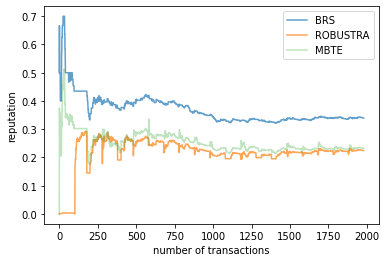

<module 'matplotlib.pyplot' from '/Users/xahiru/miniconda/envs/anaka/lib/python3.8/site-packages/matplotlib/pyplot.py'>

In [8]:
exp1.plot(101,203)

In [9]:
exp1.ballot_stuffing_with_init(203, n_fake_t=75, n_colluders=3, n_victims=3)

203
100
101
102
103


2596
2596
2596


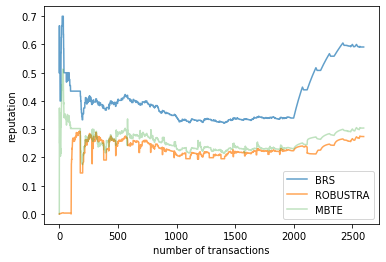

In [10]:
plt = exp1.plot(101,203)

In [30]:
plt.savefig('ballotstuffing.png', bbox_inches='tight')

<Figure size 432x288 with 0 Axes>

In [31]:

# exp1.i_transactions([(101,204)], [(101,204)], True, 100)
# exclude_pair=[], pair_list =[], target=False,


2596
2596
2596


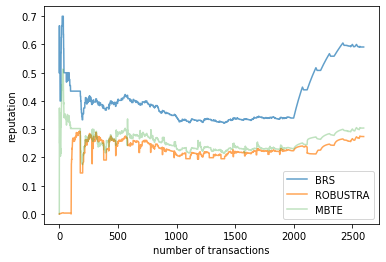

<module 'matplotlib.pyplot' from '/Users/xahiru/miniconda/envs/anaka/lib/python3.8/site-packages/matplotlib/pyplot.py'>

In [11]:
exp1.plot(101,203)

2596
2596
2596


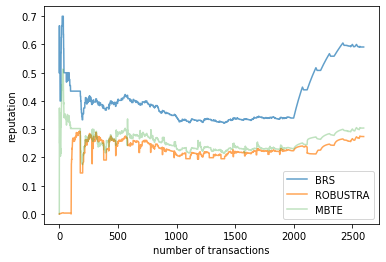

<module 'matplotlib.pyplot' from '/Users/xahiru/miniconda/envs/anaka/lib/python3.8/site-packages/matplotlib/pyplot.py'>

In [12]:
exp1.plot(101,203)

In [13]:
exp1.get_rep(101, 203, reptype='rob', alpha=0.8, filter_threshold=0.5)

0.2739437751999242

In [14]:
scenario = 1
n_consumers = 20
n_producers = 5
n_transactions = 100
seed = 100

%matplotlib inline

exp2 = Experiment(scenario, n_consumers, n_producers, n_transactions,seed)
# exp2.alpha =0.7
exp2.i_transactions([(101,203)], [(101,203)], True, t_per_user=100)
exp2.bad_mouthing(203, observers_id=[101], n_fake_t=500, n_colluders=5, n_victims=1)

experiment1 initialised with20 c and 5 p
initalizing 1  with100 t_per_user for 20 c
2000


2629
2629
2629


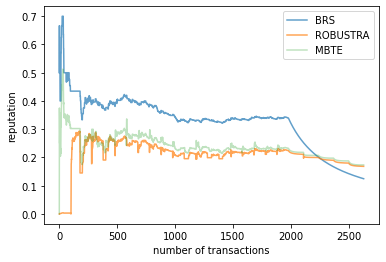

<module 'matplotlib.pyplot' from '/Users/xahiru/miniconda/envs/anaka/lib/python3.8/site-packages/matplotlib/pyplot.py'>

In [15]:
exp2.plot(101,203)

experiment0 initialised with20 c and 5 p
initalizing 0  with100 t_per_user for 20 c
2000
1980
1980
1980


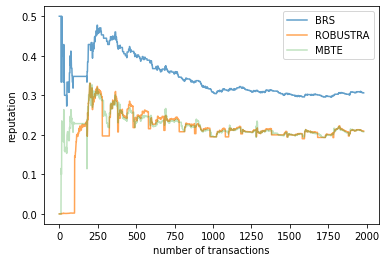

<module 'matplotlib.pyplot' from '/Users/xahiru/miniconda/envs/anaka/lib/python3.8/site-packages/matplotlib/pyplot.py'>

In [16]:
exp1.reset_all()
exp1.i_transactions([(101,204)], [(101,204)], True, 100)
exp1.plot(101,204)

In [17]:
exp1.get_rep(101, 204, reptype='rob', alpha=0.8, filter_threshold=0.5)

0.20951477883396466

In [18]:

exp1.ballot_stuffing(204, observers_id=[101], n_fake_t=500, n_colluders=3, n_victims=3)

3463
3463
3463


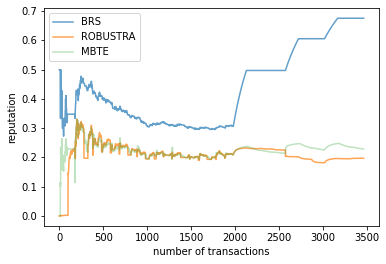

<module 'matplotlib.pyplot' from '/Users/xahiru/miniconda/envs/anaka/lib/python3.8/site-packages/matplotlib/pyplot.py'>

In [19]:
exp1.plot(101,204)

In [20]:
exp1.ballot_stuffing(204, observers_id=[101], n_fake_t=500, n_colluders=1, n_victims=3)

4363
4363
4363


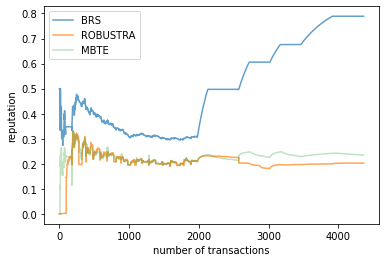

<module 'matplotlib.pyplot' from '/Users/xahiru/miniconda/envs/anaka/lib/python3.8/site-packages/matplotlib/pyplot.py'>

In [21]:
exp1.plot(101,204)

In [104]:
exp1.total_transactions_for_all

7609

In [105]:
exp1.consumers[101].total_interactions

525

In [106]:
# exp1.get_rep(110, 200, reptype='mod')

In [107]:
exp1.get_rep(101, 204, reptype='mod')

0.23484788636312173

In [108]:
# exp1.get_rep(110, 200, reptype='bayes')

In [109]:
exp1.get_rep(101, 204, reptype='bayes')

0.7889837083010085

In [110]:
# exp1.get_rep(110, 200, reptype='rob', alpha=0.8, filter_threshold=0.4)

In [111]:
exp1.get_rep(101, 204, reptype='rob', alpha=0.8, filter_threshold=0.5)

0.20273140249471586

experiment0 initialised with20 c and 10 p
initalizing 0  with100 t_per_user for 20 c
2000
2000
2000
2000


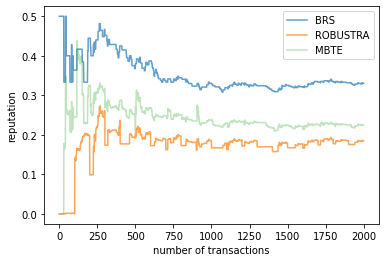

<module 'matplotlib.pyplot' from '/Users/xahiru/miniconda/envs/anaka/lib/python3.8/site-packages/matplotlib/pyplot.py'>

In [22]:
scenario = 0
n_consumers = 20
n_producers = 10
n_transactions = 100
seed = 100


%matplotlib inline

exp1 = Experiment(scenario, n_consumers, n_producers, n_transactions,seed)

# exp1.reset_all()
exp1.i_transactions([], [(101,204)], True, 100)
exp1.plot(101,204)

In [23]:
exp1.majority_descrimination(204, observers_id=[101], n_fake_t=70)

3715
3715
3715


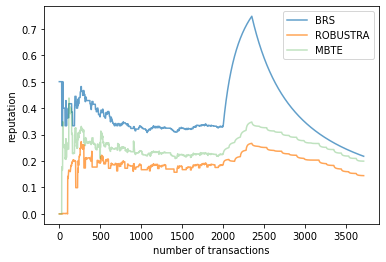

<module 'matplotlib.pyplot' from '/Users/xahiru/miniconda/envs/anaka/lib/python3.8/site-packages/matplotlib/pyplot.py'>

In [24]:
exp1.plot(101,204)

3715
3715
3715


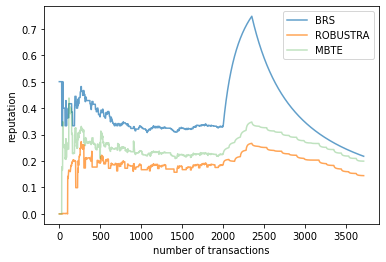

<module 'matplotlib.pyplot' from '/Users/xahiru/miniconda/envs/anaka/lib/python3.8/site-packages/matplotlib/pyplot.py'>

In [25]:
exp1.plot(110,204)

3715
3715
3715


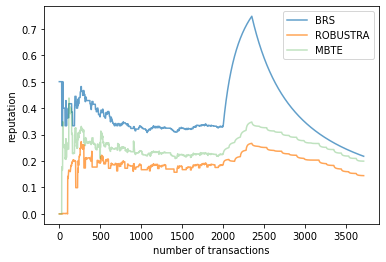

<module 'matplotlib.pyplot' from '/Users/xahiru/miniconda/envs/anaka/lib/python3.8/site-packages/matplotlib/pyplot.py'>

In [26]:
exp1.plot(109,203)

experiment0 initialised with20 c and 10 p
initalizing 0  with100 t_per_user for 20 c
2000
2000
2000
2000


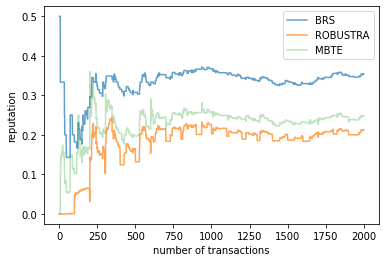

<module 'matplotlib.pyplot' from '/Users/xahiru/miniconda/envs/anaka/lib/python3.8/site-packages/matplotlib/pyplot.py'>

In [27]:
exp1.reset_all()
exp1.i_transactions([], [(101,204)], True, 100)
exp1.plot(101,204)

In [99]:
exp1.minority_descrimination(204, n_fake_t=70)

2000
2000
2000


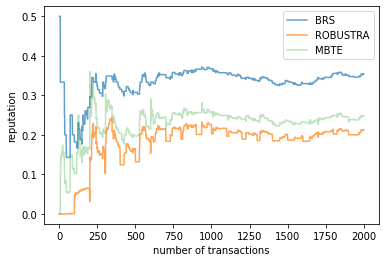

<module 'matplotlib.pyplot' from '/Users/xahiru/miniconda/envs/anaka/lib/python3.8/site-packages/matplotlib/pyplot.py'>

In [28]:
exp1.plot(101,204)

experiment0 initialised with20 c and 10 p
initalizing 0  with10 t_per_user for 20 c
200
200
200
200


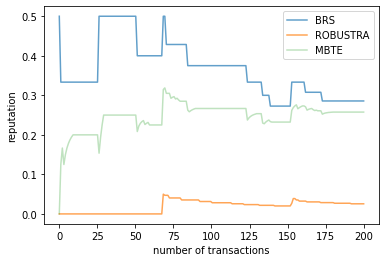

<module 'matplotlib.pyplot' from '/Users/xahiru/miniconda/envs/anaka/lib/python3.8/site-packages/matplotlib/pyplot.py'>

In [29]:
exp1.reset_all()
exp1.i_transactions([], [(101,204)], True, 10)
exp1.plot(101,204)

200
200
200


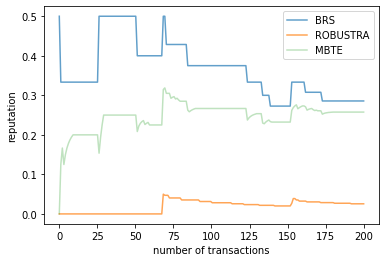

<module 'matplotlib.pyplot' from '/Users/xahiru/miniconda/envs/anaka/lib/python3.8/site-packages/matplotlib/pyplot.py'>

In [30]:
exp1.plot_re_entry(101,204,  dlen=200)

In [31]:
scenario = 0
n_consumers = 1
n_producers = 1
n_transactions = 100
seed = 100

%matplotlib inline

exp2 = Experiment(scenario, n_consumers, n_producers, n_transactions,seed)
exp2.alpha = 1
exp2.filter_threshold = 0
exp2.iwindow = True
exp2.i_transactions([], [], False, 110)

experiment0 initialised with1 c and 1 p
initalizing 0  with110 t_per_user for 1 c
110


11
11
11


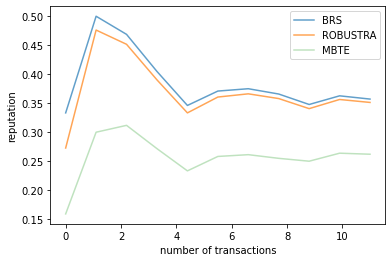

<module 'matplotlib.pyplot' from '/Users/xahiru/miniconda/envs/anaka/lib/python3.8/site-packages/matplotlib/pyplot.py'>

In [32]:
exp2.plot(100,200)

In [33]:
scenario = 0
n_consumers = 5
n_producers = 2
n_transactions = 15
seed = 100

%matplotlib inline

exp3 = Experiment(scenario, n_consumers, n_producers, n_transactions,seed)

experiment0 initialised with5 c and 2 p


In [34]:
# exp3.minority_descrimination(204, observers_id=[101], n_fake_t=2)
exp3.disagree(exp3.consumers[101], exp3.producers[201], 5)
exp3.interact_normally( exp3.consumers[101], exp3.producers[201], n_trans= 10)
# exp3.interact_normally(exp3.producers[204], exp3.consumers[102], n_trans= 15)
exp3.interact_normally( exp3.consumers[103], exp3.producers[201], n_trans= 20)
exp3.interact_normally(exp3.consumers[102], exp3.producers[201], n_trans= 20)
# exp3.interact_normally(exp3.producers[201], exp3.consumers[104], n_trans= 15)

50
50
50


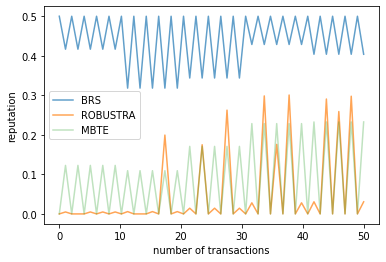

<module 'matplotlib.pyplot' from '/Users/xahiru/miniconda/envs/anaka/lib/python3.8/site-packages/matplotlib/pyplot.py'>

In [35]:
exp3.plot_re_entry(201,104, dlen=50)

In [36]:

scenario = 0
n_consumers = 20
n_producers = 5
n_transactions = 100
seed = 100

%matplotlib inline

exp4 = Experiment(scenario, n_consumers, n_producers, n_transactions,seed)

experiment0 initialised with20 c and 5 p


initalizing 0  with50 t_per_user for 20 c
1000
1000
1000
1000


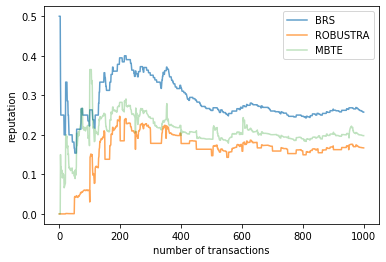

<module 'matplotlib.pyplot' from '/Users/xahiru/miniconda/envs/anaka/lib/python3.8/site-packages/matplotlib/pyplot.py'>

In [37]:
exp4.i_transactions([], [(101,204)], True, 50)
exp4.plot(101,204)

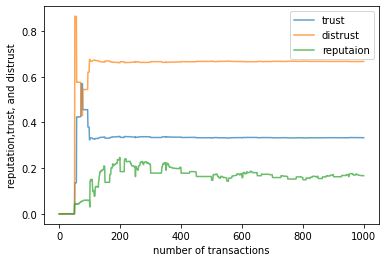

<module 'matplotlib.pyplot' from '/Users/xahiru/miniconda/envs/anaka/lib/python3.8/site-packages/matplotlib/pyplot.py'>

In [38]:
exp4.plot_trust(101,204, dlen=1000, start=0)

In [39]:
scenario = 0
n_consumers = 20
n_producers = 5
n_transactions = 100
seed = 100

%matplotlib inline

exp5 = Experiment(scenario, n_consumers, n_producers, n_transactions,seed)

experiment0 initialised with20 c and 5 p


In [40]:
exp5.i_transactions([(101,204)], [(101,204)], True, t_per_user=10)

initalizing 0  with10 t_per_user for 20 c
200


199
199
199


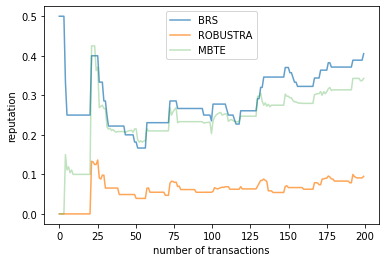

<module 'matplotlib.pyplot' from '/Users/xahiru/miniconda/envs/anaka/lib/python3.8/site-packages/matplotlib/pyplot.py'>

In [41]:
exp5.plot(102,204)

In [42]:
exp5.complementary(101, 204, n_fake_t=70, case=1)

1606
1606
1606


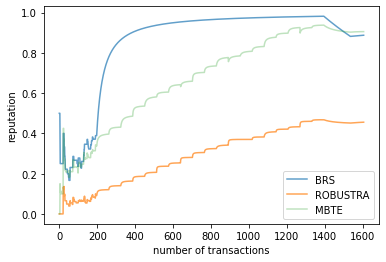

<module 'matplotlib.pyplot' from '/Users/xahiru/miniconda/envs/anaka/lib/python3.8/site-packages/matplotlib/pyplot.py'>

In [43]:
exp5.plot(100,204)

experiment0 initialised with20 c and 5 p
initalizing 0  with10 t_per_user for 20 c
200
1141
1141
1141


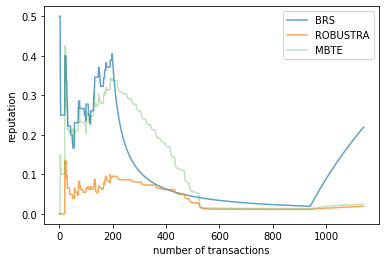

<module 'matplotlib.pyplot' from '/Users/xahiru/miniconda/envs/anaka/lib/python3.8/site-packages/matplotlib/pyplot.py'>

In [44]:
scenario = 0
n_consumers = 20
n_producers = 5
n_transactions = 100
seed = 100

%matplotlib inline

exp5 = Experiment(scenario, n_consumers, n_producers, n_transactions,seed)
exp5.i_transactions([(101,204)], [(101,204)], True, t_per_user=10)
exp5.complementary(101, 204, n_fake_t=200, case=2)
exp5.plot(100,204)

In [ ]:
##Todo
# Add lables to axis